### In this file, I'll train a deep model to classify two plant families in Saudi Arabia using binary classification.

#### This file covers the following :
- Splitting the data to training/validation sets.
- Reading the files using keras.
- For imbalanced datasets, calculate class weights using *sklearn.utils.class_weight.compute_class_weight*. Please note that the data is not imbalanced but adding this step helped in improving the model accuracy. 
- Building CNN model.
- Predicting.

#### Importing :

In [48]:
# To read the data :
import pandas as pd
# To split the data :
from sklearn.model_selection import train_test_split
# Reading :
from keras_preprocessing.image import ImageDataGenerator
# To calculate class weights :
from sklearn.utils import class_weight 
import numpy as np
# Building the model :
from keras.layers import Activation, Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
# plot :
import matplotlib.pyplot as plt
# Predicting :
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image


### Reading data :

In [2]:
data = pd.read_csv('data/data.csv')

Binary Classfication data : 

In [3]:
names = ['CARYOPHYLLACEAE','BORAGINACEAE']
BC_data = data.loc[data['label'].isin(names)]
BC_data.shape

(3839, 2)

### Splitting :

In [8]:
train_split=.70  

train_df, valid_df= train_test_split(BC_data, train_size=train_split, shuffle=True, random_state=123)

train_df.to_csv(r".\data\train.csv", index =None)
valid_df.to_csv(r".\data\valid.csv", index =None)


In [9]:
train=pd.read_csv(r".\data\train.csv")
validate=pd.read_csv(r".\data\valid.csv")

validate.shape

(1152, 2)

### Reading the files using keras :

In [10]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range = (0.5, 1.5),
    rescale=1./255
    )
valid_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
# categorical
train_generator=train_datagen.flow_from_dataframe(dataframe=train, directory=".\train_imgs", x_col="img", y_col="label", class_mode='binary', target_size=(32,32), batch_size=32)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=validate, directory=".\valid_imgs", x_col="img", y_col="label", class_mode='binary', target_size=(32,32), batch_size=32)

Found 2687 validated image filenames belonging to 2 classes.
Found 1152 validated image filenames belonging to 2 classes.


### calculate class weights:

In [40]:
class_weights = class_weight.compute_class_weight(
    class_weight= "balanced",
            classes = np.unique(train_generator.classes), 
            y=train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

Steps computing :

In [12]:
steps_per_epoch  = len(train) // 32
print("steps per epoch:{}".format(steps_per_epoch))
validation_steps = len(validate)//32
print("steps per epoch:{}".format(validation_steps))

steps per epoch:83
steps per epoch:36


### CNN Model :

In [57]:

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32,32,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.50))
model.add(Dense(1, activation='sigmoid'))

In [58]:
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                        

In [59]:
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    epochs=50,
    validation_steps=validation_steps,
    batch_size=132,
    callbacks=EarlyStopping(patience=5),
    class_weight= train_class_weights,
    verbose=2)

Epoch 1/50
83/83 - 12s - loss: 0.6954 - accuracy: 0.5060 - val_loss: 0.6930 - val_accuracy: 0.5078 - 12s/epoch - 149ms/step
Epoch 2/50
83/83 - 15s - loss: 0.6936 - accuracy: 0.5089 - val_loss: 0.6930 - val_accuracy: 0.5148 - 15s/epoch - 186ms/step
Epoch 3/50
83/83 - 17s - loss: 0.6936 - accuracy: 0.5111 - val_loss: 0.6911 - val_accuracy: 0.5182 - 17s/epoch - 202ms/step
Epoch 4/50
83/83 - 17s - loss: 0.6931 - accuracy: 0.5130 - val_loss: 0.6908 - val_accuracy: 0.5425 - 17s/epoch - 201ms/step
Epoch 5/50
83/83 - 15s - loss: 0.6868 - accuracy: 0.5605 - val_loss: 0.6687 - val_accuracy: 0.6345 - 15s/epoch - 181ms/step
Epoch 6/50
83/83 - 14s - loss: 0.6744 - accuracy: 0.5879 - val_loss: 0.6815 - val_accuracy: 0.5599 - 14s/epoch - 164ms/step
Epoch 7/50
83/83 - 14s - loss: 0.6707 - accuracy: 0.5902 - val_loss: 0.6535 - val_accuracy: 0.6137 - 14s/epoch - 172ms/step
Epoch 8/50
83/83 - 13s - loss: 0.6603 - accuracy: 0.6139 - val_loss: 0.6417 - val_accuracy: 0.6207 - 13s/epoch - 162ms/step
Epoch 9/

In [60]:
results = pd.DataFrame(history.history)


<AxesSubplot:>

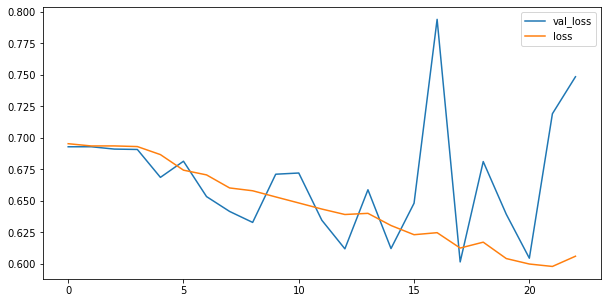

In [61]:
results[['val_loss', 'loss']].plot(figsize=(10, 5))

<AxesSubplot:>

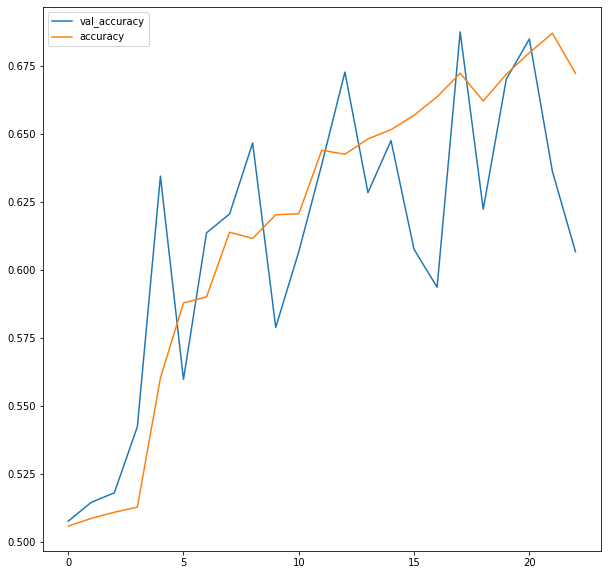

In [62]:
results[['val_accuracy', 'accuracy']].plot(figsize=(10, 10))

In [ ]:
# saving the model : 
#model.save("./model/flora.h5")

#### Predicting using the model :

In [27]:
def pred(img_path):
    img = image.load_img(img_path, target_size=(32, 32))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    preprocessed_img = preprocess_input(img_batch)

    
    prediction = model.predict(preprocessed_img)

    print(prediction[0])
    #print(type(prediction))


In [38]:
# class = CARYOPHYLLACEAE = 0 
pred0 = r".\data\images\CARYOPHYLLACEAE\dr_3_5661.jpg"
# class = CARYOPHYLLACEAE = 1
pred1 = r".\data\images\BORAGINACEAE\dr_10_7234.jpg" 

In [39]:
pred(pred0)

[0.]


In [31]:
pred(pred1)

[1.]
